# Анализ данных состояния телеграм-канала города Инноплоис

Заказчик исследования - маркетинговый отдел города Иннополис. Иннополис – первый и пока единственный российский город для ИТ-специалистов, построенный с нуля. Необходимо проанализировать городской телеграм-канал и предложить пути для увеличения лояльности аудитории. Повышение лояльности необходимо для того, чтобы читатели канала в будущем стали жителями Иннополиса.

**Цель:**

Увеличение лояльной аудитории бренда путем увеличения количества
подписчиков телеграм-канала @innopolistg.


**Задачи:**

1. Анализ нынешнего состояния телеграм-канала города;
2. Выявить, наиболее эффективные и точные метрики для
еженедельного/ежемесячного анализа работы. Формирование списка KPI для
дальнейшей работы и отслеживания заказчиком совместно с маркетологами.

**Ход анализа:**

1. Загрузка библиотек, ознакомление с данными
2. Предобработка данных
3. Анализ данных:
  - выделение тем публикаций;
  - вывод метрик эффективности поста;

    a. Тип публикации \
    b. Тема \
    c. Объем текста \
    d. Отсутствие / наличие эмодзи
    e. Знаки препинания (сложность текста)
  - облако слов;
  - популяность тем;
  - определение лучшего времени для публикаций;
  - семантический анализ комментариев к постам
  - анализ эмодзи
4. Выводы

## Загрузка библиотек, ознакомление с данными

In [1]:
!pip install --upgrade gspread # библиотека Python, которая облегчает работу с Google Sheets через их API
!pip install pandas nltk pymorphy2 wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 670.2 kB/s eta 0:00:00
  Attempting uninstall: gspread
    Found existing installation: gspread 3.4.2
    Uninstalling gspread-3.4.2:
      Successfully uninstalled gspread-3.4.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 640.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 22.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=a6461e4c889169616e39b40cc17eda7210420f60e787e8dfb0f076a60ea7797e
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [2]:
import pandas as pd
import datetime as dt
from scipy import stats as st

from wordcloud import WordCloud
import string
import ast
import re

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import pymorphy2
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import seaborn as sns
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots


import numpy as np
from google.colab import auth #аутентификация в сервисах Google в среде Colab
auth.authenticate_user() #вызывает функцию аутентификации пользователя для доступа к его учетной записи Google.
import gspread #импортирует модуль gspread, который позволяет работать с Google Sheets через Python.
from google.auth import default # импортирует функцию default из модуля google.auth, предоставляющую способы получения учетных данных аутентификации.
creds, _ = default() # - использует функцию default() для получения учетных данных аутентификации и присваивает их переменной creds

gc = gspread.authorize(creds) #использует полученные учетные данные для авторизации в gspread, создавая объект gc, который может взаимодействовать с Google Sheets через AP

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [3]:
#функция для открытия файла с данными
def open_file(key,name):
  Da = gc.open_by_key(key)
  Da_df = Da.worksheet(name)
  rows = Da_df.get_all_values() #Эти значения будут представлены в виде списка списков, где каждый внутренний список содержит значения из строки таблицы.
  df = pd.DataFrame.from_records(rows[1:], columns = rows[0])
  return df

In [4]:
df_comm = open_file('1mRkvBVMX8NGx9Crm0JmlZoLj9EGmyWcbyKIzwe7p2q8', 'comments_innopolistg_061223')
df_tg = open_file('1ZIWybT64QSKF7dO68mok_mHDBUyVVeqadBqy9nJCo50', 'innopolistg')
df_emoji = open_file('1U32kXNVuHOCfSElRy2f8i3In47k3P_g-UItMrzwwvPI', 'innopolistg_emoji')


In [5]:
#таблица с комментариями к публикациям
display(df_comm.head())
display(df_comm.info())
display('Число явных дубликатов:', df_comm.duplicated().sum())

,,post_id,date_comment,text_comment
0,0,1421,2023-12-06 12:42:17+00:00,💔
1,1,1421,2023-12-06 12:42:40+00:00,
2,2,1421,2023-12-06 12:46:43+00:00,Предлагаю также в других номинациях голосовать...
3,3,1421,2023-12-06 13:55:10+00:00,❤️
4,4,1420,2023-12-05 06:04:14+00:00,"Очень интересное сотрудничество! Уверен, что в..."


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2511 entries, 0 to 2510
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0                 2511 non-null   object
 1   post_id       2511 non-null   object
 2   date_comment  2511 non-null   object
 3   text_comment  2511 non-null   object
dtypes: object(4)
memory usage: 78.6+ KB


None

'Число явных дубликатов:'

0

In [6]:
display(df_tg.head())
display(df_tg.info())
display('Число явных дубликатов:', df_tg.duplicated().sum())

,,channel,id,date,text,views,reactions_count,comments,type_attachment
0,0,https://t.me/innopolistg,1414,2023-12-04 09:31:49+00:00,1. Университет Иннополис [открыл штаб-квартиру...,1445.0,31,0,MessageMediaPhoto
1,7,https://t.me/innopolistg,1407,2023-12-01 14:40:01+00:00,Провели дискуссию о будущем туризма в Иннополи...,2234.0,51,2,MessageMediaPhoto
2,8,https://t.me/innopolistg,1406,2023-12-01 04:16:17+00:00,Настала пора открывать подарки\n\nПоговаривают...,2823.0,109,2,MessageMediaPhoto
3,9,https://t.me/innopolistg,1404,2023-11-30 14:05:01+00:00,**Новогодний адвент-календарь** **Иннополиса**...,3284.0,120,10,MessageMediaPhoto
4,10,https://t.me/innopolistg,1403,2023-11-29 16:05:06+00:00,Начинаем вечер-дискуссию о туризме в Иннополис...,4350.0,31,1,MessageMediaPhoto


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536 entries, 0 to 535
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0                    536 non-null    object
 1   channel          536 non-null    object
 2   id               536 non-null    object
 3   date             536 non-null    object
 4   text             536 non-null    object
 5   views            536 non-null    object
 6   reactions_count  536 non-null    object
 7   comments         536 non-null    object
 8   type_attachment  536 non-null    object
dtypes: object(9)
memory usage: 37.8+ KB


None

'Число явных дубликатов:'

0

In [7]:
display(df_emoji.head())
display(df_emoji.info())
display('Число явных дубликатов:', df_emoji.duplicated().sum())

,,index,channel,id,date,text,views,reactions_count,comments,type_attachment,reactions
0,0,5,https://t.me/innopolistg,1421,2023-12-06 12:41:17+00:00,2023 год подходит к концу. И мы вспоминаем сам...,2294.0,45,4,MessageMediaPhoto,"{'_': 'MessageReactions', 'results': [{'_': 'R..."
1,1,6,https://t.me/innopolistg,1420,2023-12-05 06:01:58+00:00,В поисках новых подарков Дед Мороз заглянул в ...,2116.0,36,6,MessageMediaPhoto,"{'_': 'MessageReactions', 'results': [{'_': 'R..."
2,2,11,https://t.me/innopolistg,1415,2023-12-04 15:15:49+00:00,В первую неделю зимы слушаем классическую музы...,2175.0,22,3,MessageMediaPhoto,"{'_': 'MessageReactions', 'results': [{'_': 'R..."
3,3,12,https://t.me/innopolistg,1414,2023-12-04 09:31:49+00:00,1. Университет Иннополис [открыл штаб-квартиру...,2391.0,38,0,MessageMediaPhoto,"{'_': 'MessageReactions', 'results': [{'_': 'R..."
4,4,19,https://t.me/innopolistg,1407,2023-12-01 14:40:01+00:00,Провели дискуссию о будущем туризма в Иннополи...,2819.0,52,2,MessageMediaPhoto,"{'_': 'MessageReactions', 'results': [{'_': 'R..."


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539 entries, 0 to 538
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0                    539 non-null    object
 1   index            539 non-null    object
 2   channel          539 non-null    object
 3   id               539 non-null    object
 4   date             539 non-null    object
 5   text             539 non-null    object
 6   views            539 non-null    object
 7   reactions_count  539 non-null    object
 8   comments         539 non-null    object
 9   type_attachment  539 non-null    object
 10  reactions        539 non-null    object
dtypes: object(11)
memory usage: 46.4+ KB


None

'Число явных дубликатов:'

0

Наблюдения:
 - все столбцы в каждом датасете имеют тип object;
 - пропусков и явных дубликатов в данных нет;
 - первый безымянный столбец содержит индексы строк;
 - остальные названия столбцов корректные;
 - таблица df_emoji идентична df_tg, но в ней на 1 столбец больше данных и больше строк, поэтому для анализа выберем именно df_emoji.

## Предобработка данных

По информации о датасете df_comm видно, что пропусков в данных нет. Но если смотреть на сами данные, то видны пропуски в столбце "text_comment". При анализе пропусков получаем, что это или gif, или фото. Заменим такие пропуски на "media"

In [8]:
display(df_comm.query('text_comment==""'))

,,post_id,date_comment,text_comment
1,1,1421,2023-12-06 12:42:40+00:00,
23,23,1404,2023-11-30 15:15:56+00:00,
26,26,1404,2023-11-30 15:21:50+00:00,
69,69,1376,2023-11-22 00:53:21+00:00,
70,70,1376,2023-11-22 00:53:21+00:00,
...,...,...,...,...
2482,2482,101,2022-04-29 13:52:53+00:00,
2490,2490,74,2022-04-18 16:14:51+00:00,
2496,2496,68,2022-04-15 14:39:25+00:00,
2499,2499,68,2022-04-15 14:41:43+00:00,


In [9]:
for i in range(df_comm.shape[0]):
  if df_comm.loc[i,'text_comment'] =="" : df_comm.loc[i,'text_comment'] = 'media'

In [10]:
# удалим технический столбец из df
df_emoji = df_emoji.drop(columns='')
df_comm = df_comm.drop(columns='')

In [11]:
# заменим тип данных для столбцов с датами во всех df
df_emoji['date'] = pd.to_datetime(df_emoji['date'])
df_comm['date_comment'] = pd.to_datetime(df_comm['date_comment'])

In [12]:
# заменим тип данных для столбцов с числами во всех df
df_emoji['views'] = df_emoji['views'].astype('float')
df_emoji[['index','id', 'views', 'reactions_count', 'comments']] =df_emoji[['index','id', 'views', 'reactions_count', 'comments']].astype('int')
df_comm['post_id'] =df_comm['post_id'].astype('int')


Посмотрим периоды времени за которые предоставлены данные

In [13]:
display(df_comm['date_comment'].min())
display(df_comm['date_comment'].max())

Timestamp('2022-04-05 15:05:17+0000', tz='UTC')

Timestamp('2023-12-06 14:52:48+0000', tz='UTC')

In [14]:
display(df_emoji['date'].min())
display(df_emoji['date'].max())

Timestamp('2022-03-01 13:11:03+0000', tz='UTC')

Timestamp('2023-12-06 12:41:17+0000', tz='UTC')

Нам представлены данные о публикациях с 1 марта 2022 года по 6 декабря 2023 года.

В таблце df_comm данные только с 5 апреля 2022, это связано с тем, что до этого комментарии к постам были закрыты.

In [15]:
display(df_emoji.tail(15))

,index,channel,id,date,text,views,reactions_count,comments,type_attachment,reactions
524,1294,https://t.me/innopolistg,51,2022-03-23 12:00:00+00:00,Коллеги из [Университета Иннополис](https://t....,2796,38,0,MessageMediaPhoto,"{'_': 'MessageReactions', 'results': [{'_': 'R..."
525,1295,https://t.me/innopolistg,50,2022-03-17 13:03:28+00:00,"**Россия станет третьей страной в мире, где по...",2605,43,0,MessageMediaPhoto,"{'_': 'MessageReactions', 'results': [{'_': 'R..."
526,1296,https://t.me/innopolistg,49,2022-03-16 15:10:38+00:00,И ещё о российских продуктах\n\nАналитики Унив...,1803,21,0,,"{'_': 'MessageReactions', 'results': [{'_': 'R..."
527,1297,https://t.me/innopolistg,48,2022-03-15 15:55:15+00:00,Различные сервисы перестают работать в России ...,1823,43,0,,"{'_': 'MessageReactions', 'results': [{'_': 'R..."
528,1301,https://t.me/innopolistg,44,2022-03-14 15:50:05+00:00,Как выглядят новые объекты Иннополиса сегодня\...,1573,30,0,MessageMediaPhoto,"{'_': 'MessageReactions', 'results': [{'_': 'R..."
529,1302,https://t.me/innopolistg,43,2022-03-14 09:38:41+00:00,В мае Иннополис во второй раз станет площадкой...,3080,10,0,MessageMediaPhoto,"{'_': 'MessageReactions', 'results': [{'_': 'R..."
530,1303,https://t.me/innopolistg,42,2022-03-11 14:18:18+00:00,"Делимся полезной инфой для тех, кто ищет возмо...",2156,9,0,MessageMediaPhoto,"{'_': 'MessageReactions', 'results': [{'_': 'R..."
531,1308,https://t.me/innopolistg,37,2022-03-06 08:48:25+00:00,Впереди много выходных — советуем передохнуть ...,1434,16,0,MessageMediaPhoto,"{'_': 'MessageReactions', 'results': [{'_': 'R..."
532,1309,https://t.me/innopolistg,36,2022-03-05 14:03:28+00:00,**В ОЭЗ «Иннополис» прошли питчи новых** **про...,2312,10,0,MessageMediaPhoto,"{'_': 'MessageReactions', 'results': [{'_': 'R..."
533,1310,https://t.me/innopolistg,35,2022-03-03 14:45:32+00:00,Это залипательные трёхмерные HD-карты. Они пом...,1125,14,0,MessageMediaDocument,"{'_': 'MessageReactions', 'results': [{'_': 'R..."


In [16]:
display(df_emoji['type_attachment'].unique())

array(['MessageMediaPhoto', 'MessageMediaDocument', '',
       'MessageMediaWebPage'], dtype=object)

In [17]:
display(df_emoji.query('type_attachment==""'))

,index,channel,id,date,text,views,reactions_count,comments,type_attachment,reactions
71,207,https://t.me/innopolistg,1216,2023-09-22 09:17:10+00:00,"6 коротких ответов, которые помогут сделать Ин...",5497,20,0,,"{'_': 'MessageReactions', 'results': [{'_': 'R..."
72,208,https://t.me/innopolistg,1215,2023-09-22 08:59:37+00:00,**Этим летом Иннополис превратился** **в кэмп ...,5539,60,2,,"{'_': 'MessageReactions', 'results': [{'_': 'R..."
102,305,https://t.me/innopolistg,1118,2023-08-18 14:13:43+00:00,На Стадионе Иннополиса проходят четвертьфиналы...,5043,42,5,,"{'_': 'MessageReactions', 'results': [{'_': 'R..."
103,308,https://t.me/innopolistg,1115,2023-08-18 08:31:16+00:00,Сегодня в 16:00 на Стадионе Иннополиса стартуе...,4926,10,0,,"{'_': 'MessageReactions', 'results': [{'_': 'R..."
104,309,https://t.me/innopolistg,1114,2023-08-17 15:14:15+00:00,Андрей Себрант про перспективы и хайп искусств...,4696,33,0,,"{'_': 'MessageReactions', 'results': [{'_': 'R..."
143,418,https://t.me/innopolistg,1004,2023-06-29 14:21:14+00:00,"Жми на кружочек и узнай, чем тебе нужно занять...",4436,15,0,,"{'_': 'MessageReactions', 'results': [{'_': 'R..."
208,590,https://t.me/innopolistg,824,2023-04-07 14:17:44+00:00,Сегодня День рунета! \n\nВспомнили его историю ⏳,3714,11,0,,"{'_': 'MessageReactions', 'results': [{'_': 'R..."
256,693,https://t.me/innopolistg,718,2023-02-02 17:04:08+00:00,Про онбординг новых и внешних сотрудников в QA,3447,0,0,,
259,698,https://t.me/innopolistg,711,2023-02-01 15:15:53+00:00,"Признаёмся, ChatGPT написал не только этот пос...",3307,29,2,,"{'_': 'MessageReactions', 'results': [{'_': 'R..."
278,747,https://t.me/innopolistg,661,2023-01-09 12:42:57+00:00,"Новостей было много, лови вторую часть нашей п...",3371,18,0,,"{'_': 'MessageReactions', 'results': [{'_': 'R..."


In [18]:
for i in range(df_emoji.shape[0]):
  if df_emoji.loc[i,'type_attachment'] == '': df_emoji.loc[i,'type_attachment'] = 'Message'

В таблице df_emoji в 48 случаях не был указан тип публикации. Если найти эти публикации непосредственно в тегерамме, то видно, что в них только текст. Поэтому присвоим таким публикациям тип "Message".

## Анализ данных

### Выделение тем публикаций

In [19]:
#создадим списки слов для каждой тематики
news = ['1.', 'В Иннополисе', 'первую новость'] #инновости
career = ['career', 'vacancies', 'vacancy', 'вакансии', 'конкурсный набор', 'найм', 'поиске работы', 'рабочих мест', 'студенческий акселератор'] #карьера
music = ['music.yandex.ru', 'okko.tv', 'playlist', 'Диджей-сет', 'плейлист'] #музыка
science = ['articles', 'nauka', 'people', 'project', 'sezinno', 'автомобиль яндекса', 'акселератор', 'акселератор industrior', 'грант', 'исследовани', 'магистратур',
           'наши выпускники', 'опубликовал журнал', 'оэз «иннополис»', 'подать заявку', 'Университ', 'стипендии'] #наука
collections = ['лови', 'мы недавно нашли', 'подборк', 'подготовили', 'поделился', 'посмотреть', 'присмотрели', 'айтишный для начинающих', 'сохраняем', 'сохраняй',
               'сохраняй в закладки',  'habr.com', 'айтишного для начинающих'] #подборки и ссылки
event = ['сегодня', '@kazandigitalweek', '8 марта', 'advent', 'backend Day', 'camp', 'congratulations', 'crossconf', 'diginavis иннополис трейл 2023', 'event', 'frontend day',
         'innoadvent', 'kazanforum', 'kazansummit', 'meetup', 'в городском парке', 'в коворкинге технопарка им. лобачевского', 'вебинар', 'Вечер джаза', 'вечеринк',
         'вот-вот начнем', 'встречаемся', 'вход свободный', 'вчера', 'где:', 'день города', 'день победы', 'день республики', 'день рождения', 'день учителя', 'дискусс',
         'ждем тебя', 'жду тебя', 'завтра', 'запускаем', 'казань экспо', 'календарь', 'когда:', 'конкурс', 'конфа', 'конференц-зал технопарка им. попова', 'конференци', 'концерт',
          'марафон', 'мероприят', 'митап', 'можно поучаствовать', 'на площади университета', 'а этой неделе', 'напоминание', 'начало в', 'начало регистрации', 'начинаем в',
         'начинается в', 'новый год', 'питч-сесси', 'планы на неделю', 'подключайся к трансляции', 'пост-напоминание', 'праздн', 'премьера', 'приглашает', 'провели', 'прошел',
         'прямой эфир', 'регистрация', 'сегодня', 'сейчас', 'соревновани', 'спектакл', 'стадионе иннополиса', 'стартовал', 'сходить', 'сыграть', 'тебя ждет', 'турнир', 'тут',
         'участие бесплатное', 'фестиваль', 'фиджитал-турнир', 'форум', 'шоу'] #событие
startup = ['стартап', 'инициатив']  #стартап
hous = ['жильё', 'большой завод', 'заканчивают возведение', 'Квартал', 'квартир', 'льготным условиям', 'новоселье', 'очередь сдадут', 'строится', 'таунхаусы',
        'открыли новые корпуса'] #стройка-жилье
tourism = ['tourism', 'travelguide', 'гайд', 'маршрут', 'отправляемся', 'туризм', 'экскурс'] #туризм


In [20]:
#присвоение тематики публикации каждой строке
for i in range(df_emoji.shape[0]):
    for mf in music:
        if mf in df_emoji.loc[i,'text']:
            df_emoji.loc[i,'theme'] = 'музыка'
    for s in science:
        if s in df_emoji.loc[i,'text']:
            df_emoji.loc[i,'theme'] = 'наука и Университет'
    for ev in event:
        if ev in df_emoji.loc[i,'text']:
            df_emoji.loc[i,'theme'] = 'события'
    for st in startup:
        if st in df_emoji.loc[i,'text']:
            df_emoji.loc[i,'theme'] = 'стартап'
    for t in tourism:
        if t in df_emoji.loc[i,'text']:
            df_emoji.loc[i,'theme'] = 'туризм'
    for c in career:
        if c in df_emoji.loc[i,'text']:
            df_emoji.loc[i,'theme'] = 'карьера'
    for col in collections:
        if col in df_emoji.loc[i,'text']:
            df_emoji.loc[i,'theme'] = 'подборки и ссылки'
    for h in hous:
        if h in df_emoji.loc[i,'text']:
            df_emoji.loc[i,'theme'] = 'стройка-жилье'
    for n in news:
        if n in df_emoji.loc[i,'text']:
            df_emoji.loc[i,'theme'] = 'инновости'


In [21]:
#если тема осталась незаполнена - заполним "фото и эмоции"
df_emoji['theme'] = df_emoji['theme'].fillna('фото и эмоции')

In [22]:
df_theme = df_emoji.groupby('theme').agg({'id':'count'}).reset_index()
df_theme.columns = ['theme','count_post']
display(df_theme.sort_values(by='count_post', ascending = False))

,theme,count_post
9,фото и эмоции,129
0,инновости,122
5,события,102
4,подборки и ссылки,59
1,карьера,43
6,стартап,35
3,наука и Университет,21
8,туризм,11
7,стройка-жилье,9
2,музыка,8


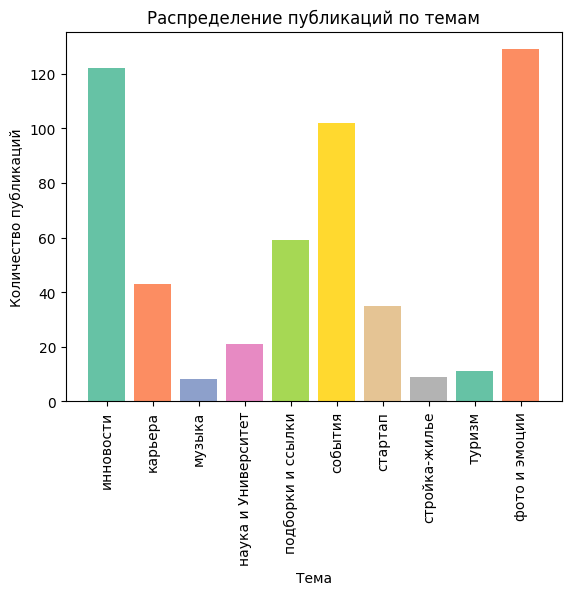

In [23]:
col_map = plt.get_cmap('Set2')
plt.bar(df_theme['theme'],df_theme['count_post'], color=col_map.colors)
plt.title('Распределение публикаций по темам')
plt.xlabel('Тема')
plt.ylabel('Количество публикаций')
plt.xticks(rotation=90)
plt.show()

In [24]:
fig = px.pie(df_theme,
             values='count_post', names='theme',
            title = 'Распределение публикаций по темам')
fig.show()

Больше всего в телеграмм-канале публикаций на тему "фото и эмоции" и "инновости", чуть меньше публикаций на тему "события". Получается, что канал в большей степени отображает насыщенную и интересную жизнь города.

Но если есть цель привлечь новых жителей в город, то стоит рассмотреть увеличение числа публикаций на тему "стройка-жилье".

### Вывод метрик эффективности поста

In [25]:
col_post = df_emoji.shape[0]
col_post_comm = df_emoji.query('date>="2022-04-01 00:00:00+0000"').shape[0] #кол-во постов для оценки комментариев, т.к. комментарии до апреля были зарыты
print('Общее количество публикаций - ', col_post)

Общее количество публикаций -  539


In [26]:
col_reactions_all = df_emoji['reactions_count'].sum()
col_comments_all = df_emoji['comments'].sum()
print('Общее количество реакций на все публикации - ', col_reactions_all)
print('Общее количество комментариев на все публикации - ', col_comments_all)

Общее количество реакций на все публикации -  25541
Общее количество комментариев на все публикации -  2511


In [27]:
avg_reactions = col_reactions_all/col_post
avg_comments = col_comments_all/col_post_comm
print('Среднее количество реакций на публикацию - ', avg_reactions.round(2))
print('Среднее количество комментариев на публикацию - ', avg_comments.round(2))

Среднее количество реакций на публикацию -  47.39
Среднее количество комментариев на публикацию -  4.83


In [28]:
#добавим столбец "вовлеченность",  который будет равен сумме реакций и комментариев относительно количества просмотров
df_emoji['involvement'] = (df_emoji['reactions_count'] + df_emoji['comments'])/df_emoji['views']
avg_involvement = df_emoji['involvement'].mean()
print('Средняя вовлеченность -', round(avg_involvement*100, 2), '%')

Средняя вовлеченность - 1.35 %


In [29]:
#создадим таблицу только с теми постами, у которых показатели "вовлеченность", "количество комментариев" и "количество реакций" выше среднего
df_good_involvement = df_emoji.query('reactions_count > @avg_reactions and comments > @avg_comments and involvement > @avg_involvement')
print('Количество публикаций, у которых все показатели выше среднего', df_good_involvement.shape[0])

Количество публикаций, у которых все показатели выше среднего 84


In [30]:
#создадим таблицу только с теми постами, у которых показатели "вовлеченность", "количество комментариев" и "количество реакций" ниже или равны среднему
no_involvement = df_emoji.query('reactions_count <= @avg_reactions and comments <= @avg_comments and involvement <= @avg_involvement')
print('Посты, у которых все показатели ниже среднего', no_involvement.shape[0])


Посты, у которых все показатели ниже среднего 265


Будем считать, что публикации собранные в таблице df_good_involvement наиболее эффективные, т.к. все показатели "вовлеченность", "количество комментариев" и "количество реакций" выше среднего. А в no_involvement - наоборот самые менее эффективные.

#### Тип публикации

In [31]:
df_grouptype_all = df_emoji.groupby('type_attachment').agg({'id':'count'}).reset_index()
df_grouptype_all.columns = ['type_attachment','all_count']
df_grouptype = df_good_involvement.groupby('type_attachment').agg({'id':'count'}).reset_index()
df_grouptype.columns = ['type_attachment','good_involvement_count'] #все публикации и "эффективыные" публикации
df_grouptype = df_grouptype_all.merge(df_grouptype, how='outer', on='type_attachment')
df_grouptype['good_involvement_count'] = df_grouptype['good_involvement_count'].fillna(0)
df_grouptype['proc'] = (df_grouptype['good_involvement_count']/df_grouptype['all_count']*100).round(2)
display(df_grouptype.sort_values(by='proc', ascending=False))

,type_attachment,all_count,good_involvement_count,proc
1,MessageMediaDocument,50,23.0,46.00
2,MessageMediaPhoto,433,60.0,13.86
0,Message,48,1.0,2.08
3,MessageMediaWebPage,8,0.0,0.00


Больше всего реакций на публикации с фото, но таких публикаций в принципе больше всего. Если рассматривать в % отношении, то почти половина публикаций с видео-файлами получила хорошие реакции.

Самые менее эффективные публикации только с текстом или с ссылками.

#### Тема публикации

In [32]:
df_grouptheme_all = df_emoji.groupby('theme').agg({'id':'count'}).reset_index()
df_grouptheme_all.columns = ['theme','all_count']
df_grouptheme = df_good_involvement.groupby('theme').agg({'id':'count'}).reset_index()
df_grouptheme.columns = ['theme','good_involvement_count']
df_grouptheme = df_grouptheme_all.merge(df_grouptheme, how='outer', on='theme')
df_grouptheme['good_involvement_count'] = df_grouptheme['good_involvement_count'].fillna(0)
df_grouptheme['proc'] = (df_grouptheme['good_involvement_count']/df_grouptheme['all_count']*100).round(2)
display(df_grouptheme.sort_values(by='proc', ascending=False))

,theme,all_count,good_involvement_count,proc
9,фото и эмоции,129,45,34.88
7,стройка-жилье,9,3,33.33
4,подборки и ссылки,59,9,15.25
5,события,102,15,14.71
2,музыка,8,1,12.50
3,наука и Университет,21,2,9.52
8,туризм,11,1,9.09
0,инновости,122,6,4.92
6,стартап,35,1,2.86
1,карьера,43,1,2.33


В процентном соотношении больше всего реакций на публикации по темам: "фото и эмоции" (таких публикаций в принципе, больше всего на канале) и "стройка-жилье".
Данный пункт подтврждает, что стоит рассмотреть увеличение публикаций на тему "стройка-жилье".

Меньше всего реакций на "эффективные" публикации по темам: "карьера", "стартап", и  "инновости".

#### Объем текста

In [33]:
df_text = df_good_involvement.reset_index().copy()
for i in range(df_text.shape[0]):
  df_text.loc[i, 'len_text'] = len(df_text.loc[i,'text'])

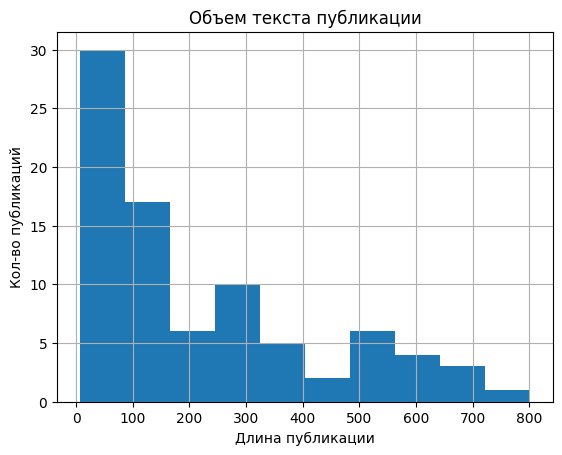

In [34]:
fig, ax = plt.subplots()
ax = df_text['len_text'].hist()
plt.title('Объем текста публикации')
plt.xlabel('Длина публикации')
plt.ylabel('Кол-во публикаций')
plt.show()

Среди "эффективных" публикаций больше  тех, у которых наименьшой объем текста.

#### Отсутствие/наличие эмодзи

In [35]:
emoji = ['🌟', '😉', '⭐️', '💜', '🎄', '💛', '👨', '🎓', '👏', '👀', '💻', '🔔', '😇', '💚', '👌', '1️⃣', '2️⃣', '3️⃣', '🤖', '❤️', '🏫', '🙌', '🏕', '🤩', '⚡️', '👩', '🎶', '👟', '💥',
         '🌷', '😲', '💫', '🐾', '💔', '🔤', '🔡', '😍', '😎', '⚠️', '⏳', '💟', '🙂', '🎧', '🌆', '🥰', '🔥', '📆', '🤗', '🧘🏻', '🏃🏻', '☺️', '✅', '🌿', '🤗', '🌌', '🧡', '😅', '🥴',
         '⬇️', '🎆', '😌', '🚩', '👋', '💪', '🥳', '🛸', '✨', '🤝', '👈', '👇', '🌐', '💾', '🎉', '🍂', '😶', '😀', '💰', '☝️', '🤔', '🔝', '📚']

In [36]:
for i in range(df_emoji.shape[0]):
  for j in emoji:
    if j in df_emoji.loc[i,'text']:
      df_emoji.loc[i,'emoji'] = True
df_emoji['emoji'] = df_emoji['emoji'].fillna(False)

In [37]:
all_emoji = df_emoji.query('emoji==True').shape[0]
print('Количество публикаций с эмоджи', all_emoji)

Количество публикаций с эмоджи 139


In [38]:
df_good_involvement = df_good_involvement.merge(df_emoji[['id','emoji']], how='left', on='id')
involvement_emoji_count = df_good_involvement.query('emoji == True').shape[0]
print('Количество "эффективных" публикаций с эмоджи', involvement_emoji_count)

Количество "эффективных" публикаций с эмоджи 41


Половина "эффективных" публикаций содержат эмоджи.  

Из всех публикаций с эмоджи 30% это "эффективные" публикации.

**ВЫВОД**

После срасчета средних показателей количества комментариев и реакций на публикацию и коэффициента вовлеченности (который равен сумме кол-ва комментариев и реакций, деленной на количество просмотров), был выделен датасет с "эффективными" публикациями - у которых, все эти показатели выше средних.

При анализе "эффективных" публикаций было выявлено:
- больше всего реакций на публикации с фото, но таких публикаций в принципе больше всего;
- почти половина публикаций с видео-файлами получила хорошие реакции;
- самые менее эффективные публикации только с текстом или с ссылками;
- больше всего реакций на публикации по темам: "фото и эмоции" и "стройка-жилье";
- меньше всего реакций по темам: "карьера", "стартап", и "инновости";
- преволируют публикации с меньшим объемом текста;
- половина "эффективных" публикаций содержат эмоджи;
- из всех публикаций с эмоджи 30% это "эффективные" публикации.


Получается "рецепт" эффективной публикации: публикация с небольшим объемом текста и наличием эмоджи, с фото или видео файлом на тему "фото и эмоции" или "стройка-жилье".

### Облако слов

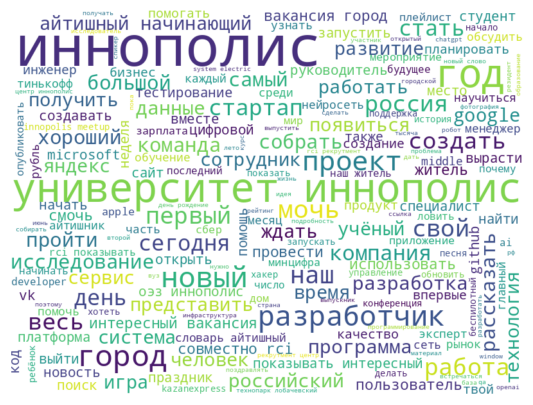

In [39]:
# Инициализация стоп-слов
stop_words = set(stopwords.words('russian'))

# Добавление собственных вариантов к списку стоп-слов
custom_stop_words = set(['это', 'еще', 'ещё', 'наиболее', 'млн', 'ия', 'который', 'http', 'всё'])

# Объединение стандартных и собственных стоп-слов
stop_words = stop_words.union(custom_stop_words)

# Инициализация лемматизатора и морфологического анализатора
morph = pymorphy2.MorphAnalyzer()
lemmatizer = WordNetLemmatizer()

# Функция для токенизации, лемматизации и удаления стоп-слов
def tokenize_lemmatize_and_filter(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(morph.parse(token)[0].normal_form) for token in tokens]
    return [token for token in lemmatized_tokens if token.lower() not in stop_words and token.isalpha()]

# Объединение текстов из столбца 'text' в одну переменную
all_text = ' '.join(df_emoji['text'].tolist())
all_text = all_text.lower()

# Токенизация, лемматизация и фильтрация стоп-слов для всего текста
all_tokens = tokenize_lemmatize_and_filter(all_text)

# Объединение токенов для создания облака слов
text_for_wordcloud = ' '.join(all_tokens)

# Создание и отображение облака слов
wordcloud = WordCloud(
    background_color='white',
    width=800,
    height=600
).generate(text_for_wordcloud)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Облако слов показывает, что чаще всего в тексте публикаций встречаются слова "иннополис", "университет иннополис". Еще выделяются слова "разработчик", "проект", "город", "работа".

### Популяность тем

In [40]:
df_theme = df_emoji.groupby('theme').agg({'id':'count', 'reactions_count':'sum', 'comments':'sum'}).sort_values(by='id', ascending=False).reset_index()
df_theme['reaction_mean'] = round(df_theme['reactions_count']/df_theme['id'], 2)
df_theme['comments_mean'] = round(df_theme['comments']/df_theme['id'], 2)
display(df_theme)

,theme,id,reactions_count,comments,reaction_mean,comments_mean
0,фото и эмоции,129,8996,882,69.74,6.84
1,инновости,122,3340,270,27.38,2.21
2,события,102,5389,632,52.83,6.20
3,подборки и ссылки,59,2646,321,44.85,5.44
4,карьера,43,1050,171,24.42,3.98
5,стартап,35,1319,55,37.69,1.57
6,наука и Университет,21,1387,39,66.05,1.86
7,туризм,11,483,36,43.91,3.27
8,стройка-жилье,9,560,60,62.22,6.67
9,музыка,8,371,45,46.38,5.62


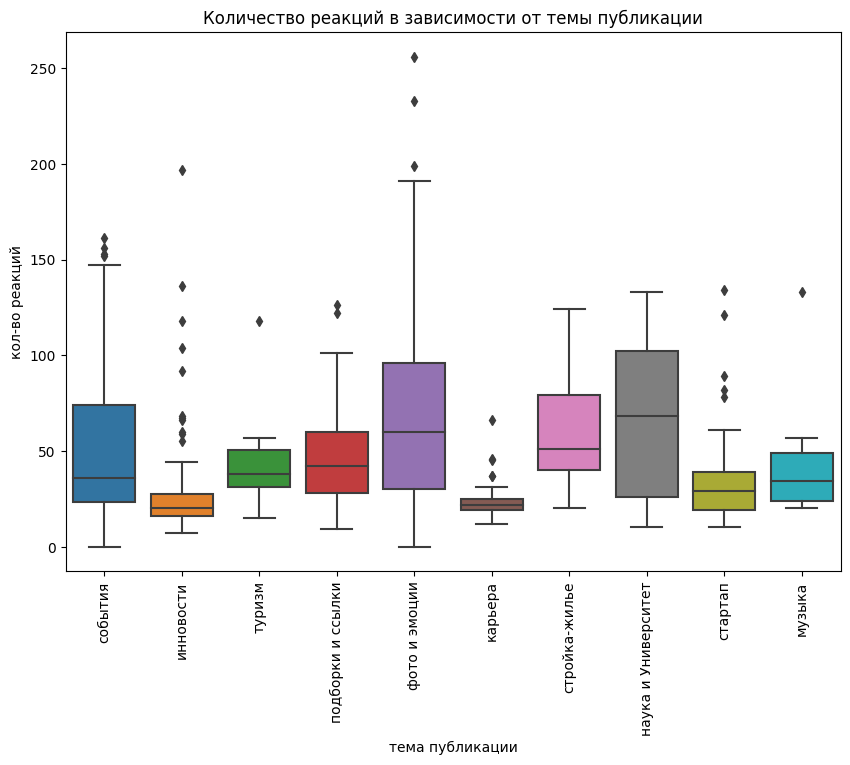

In [41]:
plt.figure(figsize=(10,7))
ax = sns.boxplot(x='theme', y='reactions_count', data=df_emoji)
plt.xticks(rotation=90)
plt.title('Количество реакций в зависимости от темы публикации')
plt.xlabel('тема публикации')
plt.ylabel('кол-во реакций')
plt.show()

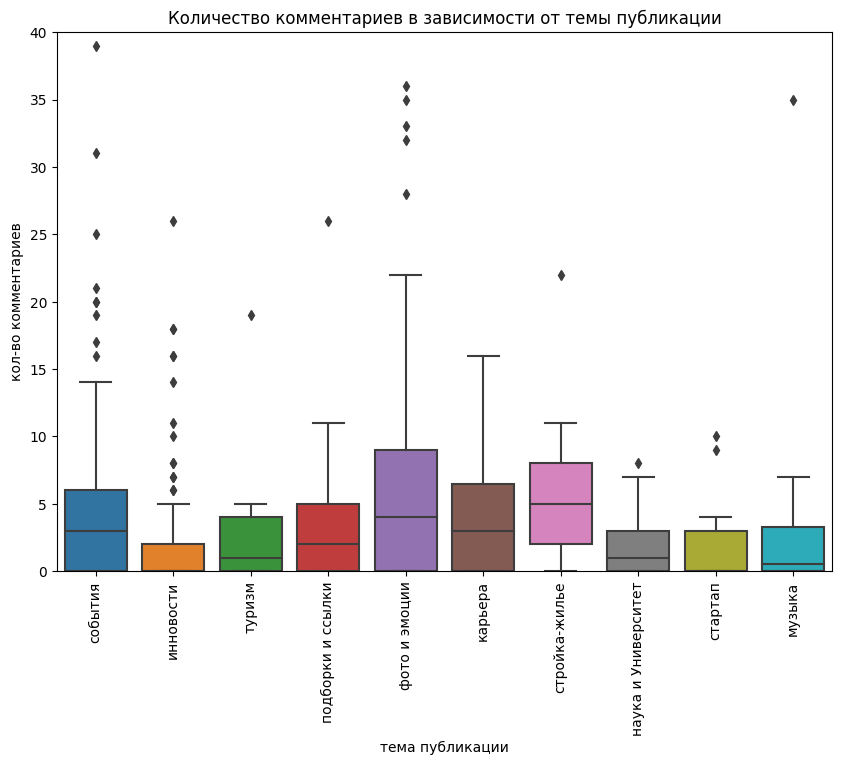

In [42]:
plt.figure(figsize=(10,7))
ax = sns.boxplot(x='theme', y='comments', data=df_emoji)
ax.set_ylim(0,40)
plt.xticks(rotation=90)
plt.title('Количество комментариев в зависимости от темы публикации')
plt.xlabel('тема публикации')
plt.ylabel('кол-во комментариев')
plt.show()

Средние значения количества реакций на публикациюю выше по темам "наука и университет" и "фото и эмоции" и "стройка-жилье", ниже всего у тем "карьера" и "инновости".

Комментариев же больше у тем "фото и эмоции", "стройка-жилье" и "события", ниже у "стартап" и "университет".  

Популярные темы: "фото и эмоции", "стройка-жилье".

Непопулярные: "карьера" и "инновости".

### Oпределение лучшего времени для публикаций

В нашем датасете время представлено в часовом поясе +00, но в Иннополисе +03. Поэтому изменим наши данные на +3 часа

In [43]:
df_hour = df_emoji.copy()
df_hour['date_h'] = df_hour['date'].dt.hour #столбец, сожержащий только час выхода публикации
df_hour_group = df_hour.groupby('date_h').agg({'id':'count', 'reactions_count':'sum', 'comments':'sum','views':'sum'}).sort_values(by='date_h').reset_index()
df_hour_group['date_h'] = df_hour_group['date_h'] + 3

In [44]:
#расчет средних показателей
df_hour_group['views_on_post'] = round(df_hour_group['views']/df_hour_group['id'],0)
df_hour_group['comments_on_post'] = round(df_hour_group['comments']/df_hour_group['id'],0)
df_hour_group['reactions_on_post'] = round(df_hour_group['reactions_count']/df_hour_group['id'],0)

In [45]:
df_hour_group

,date_h,id,reactions_count,comments,views,views_on_post,comments_on_post,reactions_on_post
0,7,2,248,14,8083,4042.0,7.0,124.0
1,8,3,295,13,13655,4552.0,4.0,98.0
2,9,6,481,29,31017,5170.0,5.0,80.0
3,10,28,1272,77,121557,4341.0,3.0,45.0
4,11,48,1942,154,179781,3745.0,3.0,40.0
5,12,82,3092,258,324347,3955.0,3.0,38.0
6,13,36,1758,130,143695,3992.0,4.0,49.0
7,14,31,2019,210,123090,3971.0,7.0,65.0
8,15,61,2562,403,245783,4029.0,7.0,42.0
9,16,68,3364,330,290093,4266.0,5.0,49.0


In [46]:
fig = px.pie(df_hour_group,
             values='id', names='date_h',
            title = 'Распределение количества публикаций по времени их появления')
fig.show()

Больше всего публикаций выпущенно в 17 часов дня, дальше 12,16, и 15 ч.

In [47]:
fig = px.bar(df_hour_group,  x='date_h', y='reactions_count')
fig.update_layout(title='Распределение количества реакций по времени выхода публикаций',
                   xaxis_title='время',
                   yaxis_title='общее кол-во реакций')
fig.show()

In [48]:
fig = px.bar(df_hour_group,  x='date_h',  y='reactions_on_post')
fig.update_layout(title='Распределение среднего количества реакций на публикацию по времени',
                   xaxis_title='время',
                   yaxis_title='среднее кол-во реакций')
fig.show()

In [49]:
fig = px.bar(df_hour_group,  x='date_h',  y='comments')
fig.update_layout(title='Распределение количества комментариев по времени выхода публикаций',
                   xaxis_title='время',
                   yaxis_title='общее кол-во комментариев')
fig.show()

In [50]:
fig = px.bar(df_hour_group,  x='date_h',  y='comments_on_post')
fig.update_layout(title='Распределение среднего количества комментариев на публикацию по времени',
                   xaxis_title='время',
                   yaxis_title='среднее кол-во комментариев')
fig.show()

In [51]:
fig = px.bar(df_hour_group, x='date_h',  y='views')
fig.update_layout(title='Распределение количества просмотров по времени выхода публикаций',
                   xaxis_title='время',
                   yaxis_title='общее кол-во просмотров')
fig.show()

In [52]:
fig = px.bar(df_hour_group, x='date_h',  y='views_on_post')
fig.update_layout(title='Распределение среднего количества просмотров публикаций по времени',
                   xaxis_title='время',
                   yaxis_title='среднее кол-во просмотров')
fig.show()

In [53]:
#анализ таблицы с комментариями
df_comm['hour'] = df_comm['date_comment'].dt.hour
df_comm_group = df_comm.groupby('hour').agg({'post_id':'nunique', 'text_comment':'count'}).sort_values(by='hour').reset_index()
df_comm_group['hour'] = df_comm_group['hour'] + 3

In [54]:
fig = px.bar(df_comm_group,  x='hour', y='text_comment')
fig.update_layout(title='Количество комментариев по времени появления комментрия',
                   xaxis_title='время',
                   yaxis_title='кол-во комментариев')
fig.show()

При анализе всех публикаций больше всего реакций, комментариев и просмотров на публикации от 17, 16, 12, 18 ч. Но это может быть связано с тем, что в это время, в принципе, выходит больше публикаций.

 Если рассматривать по среднем занчениям, то количество реакций выше на публикации от 21, 7 и 24 ч, а количество комментариев - от 21 ч. Просмотры относительно ровно распределены,немного больше на публикации от 21ч.

 При анализе таблицы с комментариями, видно, что больше всего комментариев оставляют в промежуток 16-18 ч, меньше всего с 23 ч вечера и до 10 утра.

### Cемантический анализ комментариев к постам



Сначала проанализируем таблицу с комментариями, чтобы найти те, в которых люди выражают желание приехать/переехать в Иннополис.

In [55]:
regex_pattern = r'\b(?:переезжа(?:ть|ю)|приедем|едем|рассматриваю\s+переезд|задумалась\s+о\s+переезде|поеха(?:ть|ю)|приеха(?:ть|ал(?:а)?)|перееха(?:ть|ал(?:а)?)|хочу\s+к\s+вам|хочу\s+посмотреть|съезди(?:ть|м)|люблю\s+приезжать|нужно\s+приезжать)\b'

In [56]:
# Функция для поиска совпадений с регулярным выражением в столбце text_comment
def find_matches(text):
    matches = re.findall(regex_pattern, text.lower())  # Поиск совпадений в тексте комментария
    return bool(matches)  # Возвращаем True, если есть хотя бы одно совпадение, иначе False

# Применение функции к столбцу text_comment и создание нового столбца с результатами
df_comm['has_match'] = df_comm['text_comment'].fillna('').apply(find_matches)

In [57]:
df_comm_moving = df_comm.query('has_match ==True')
id_post = df_comm_moving['post_id'].unique().tolist() # id постов, содержащие комментарии про переезд
print(id_post)

[1395, 1376, 1272, 1230, 1175, 1168, 1120, 1103, 1047, 1005, 909, 905, 883, 865, 861, 808, 728, 680, 673, 670, 646, 627, 580, 556, 528, 467, 313, 193, 182, 177, 114, 68, 63]


In [58]:
print('Количество комментариев, в которых люди выражают желание приехать/переехать в Иннополис -', df_comm_moving.shape[0])

Количество комментариев, в которых люди выражают желание приехать/переехать в Иннополис - 45


In [59]:
#получение таблицы с публикациям, в которых содержатся комментарии про переезд
df_moving = df_emoji.query('id in @id_post')
df_moving

,index,channel,id,date,text,views,reactions_count,comments,type_attachment,reactions,theme,involvement,emoji
8,30,https://t.me/innopolistg,1395,2023-11-28 12:35:08+00:00,Завтра большая и важная дискуссия для нашего г...,4463,38,5,MessageMediaPhoto,"{'_': 'MessageReactions', 'results': [{'_': 'R...",туризм,0.009635,False
16,49,https://t.me/innopolistg,1376,2023-11-21 15:27:12+00:00,Красивый заснеженный Иннополис глазами нашего ...,5011,256,20,MessageMediaDocument,"{'_': 'MessageReactions', 'results': [{'_': 'R...",фото и эмоции,0.055079,False
54,152,https://t.me/innopolistg,1272,2023-10-11 13:50:25+00:00,Телепортируемся в осенний уютный Иннополис ❤️,4006,158,10,MessageMediaDocument,"{'_': 'MessageReactions', 'results': [{'_': 'R...",фото и эмоции,0.041937,True
62,193,https://t.me/innopolistg,1230,2023-10-03 15:20:36+00:00,"Лови новые обои Иннополиса, которые скрасят тв...",3628,84,35,MessageMediaPhoto,"{'_': 'MessageReactions', 'results': [{'_': 'R...",фото и эмоции,0.032800,False
87,248,https://t.me/innopolistg,1175,2023-09-04 10:26:48+00:00,"1. Голубь с флешками [передал 3 ТБ быстрее,](h...",4258,23,11,MessageMediaPhoto,"{'_': 'MessageReactions', 'results': [{'_': 'R...",инновости,0.007985,False
88,255,https://t.me/innopolistg,1168,2023-09-01 14:25:01+00:00,Сегодня заместитель Председателя Правительства...,4484,124,11,MessageMediaPhoto,"{'_': 'MessageReactions', 'results': [{'_': 'R...",стройка-жилье,0.030107,False
100,303,https://t.me/innopolistg,1120,2023-08-21 15:45:46+00:00,Последняя неделя лета будет очень насыщенной 😲...,4199,37,5,MessageMediaPhoto,"{'_': 'MessageReactions', 'results': [{'_': 'R...",события,0.010002,True
108,320,https://t.me/innopolistg,1103,2023-08-16 08:37:07+00:00,"Ты, лето, Иннополис...💔\n\nГотовимся красиво з...",5029,59,20,MessageMediaDocument,"{'_': 'MessageReactions', 'results': [{'_': 'R...",события,0.015709,True
126,376,https://t.me/innopolistg,1047,2023-07-21 12:12:11+00:00,Совместно с RCI показываем наиболее интересные...,5293,28,6,MessageMediaPhoto,"{'_': 'MessageReactions', 'results': [{'_': 'R...",карьера,0.006424,False
142,417,https://t.me/innopolistg,1005,2023-06-30 13:10:43+00:00,Иннополис в деталях 💟\n\nКусочки футуристическ...,4526,191,12,MessageMediaPhoto,"{'_': 'MessageReactions', 'results': [{'_': 'R...",фото и эмоции,0.044852,True


In [60]:
print('Количество публикаций, в комментариях которых люди выражают желание приехать/переехать в Иннополис -', df_moving.shape[0])

Количество публикаций, в комментариях которых люди выражают желание приехать/переехать в Иннополис - 33


In [61]:
df_moving_theme = df_moving.groupby('theme').agg({'id':'count'}).reset_index()
display(df_moving_theme.sort_values(by='id', ascending=False))

,theme,id
6,фото и эмоции,13
3,события,8
1,карьера,3
2,подборки и ссылки,3
4,стройка-жилье,3
0,инновости,2
5,туризм,1


In [62]:
fig = px.pie(df_moving_theme,
             values='id', names='theme',
            title = 'Распределение выделенных публикаций по темам')
fig.show()

In [63]:
# Инициализация стоп-слов
stop_words = set(stopwords.words('russian'))

# Добавление собственных вариантов к списку стоп-слов
custom_stop_words = set(['это', 'еще', 'ещё', 'наиболее', 'млн', 'ия', 'который', 'http', 'всё'])

# Объединение стандартных и собственных стоп-слов
stop_words = stop_words.union(custom_stop_words)

# Инициализация лемматизатора и морфологического анализатора
morph = pymorphy2.MorphAnalyzer()
lemmatizer = WordNetLemmatizer()

# Функция для токенизации, лемматизации и удаления стоп-слов
def tokenize_lemmatize_and_filter(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(morph.parse(token)[0].normal_form) for token in tokens]
    return [token for token in lemmatized_tokens if token.lower() not in stop_words and token.isalpha()]

# Функция для токенизации, лемматизации и удаления стоп-слов с учетом вариаций слова "иннополис"
def tokenize_lemmatize_and_filter_with_innopolis(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = []
    i = 0
    while i < len(tokens):
        token = tokens[i]
        lem_token = lemmatizer.lemmatize(morph.parse(token)[0].normal_form)
        if lem_token.lower() == 'университет' and i + 1 < len(tokens) and morph.parse(tokens[i + 1])[0].normal_form.lower() == 'иннополис':
            lemmatized_tokens.append('университет иннополис')
            i += 2
        else:
            lemmatized_tokens.append(lem_token)
            i += 1
    return [token for token in lemmatized_tokens if token.lower() not in stop_words and token.isalpha()]

# Объединение текстов из столбца 'text' в одну переменную
all_text = ' '.join(df_moving['text'].tolist())
all_text = all_text.lower()

# Токенизация, лемматизация и фильтрация стоп-слов для всего текста
all_tokens = tokenize_lemmatize_and_filter(all_text)
# Токенизация, лемматизация и фильтрация стоп-слов с учетом вариаций слова "иннополис"
all_tokens = tokenize_lemmatize_and_filter_with_innopolis(all_text)

# Объединение токенов для создания облака слов
text_for_wordcloud = ' '.join(all_tokens)

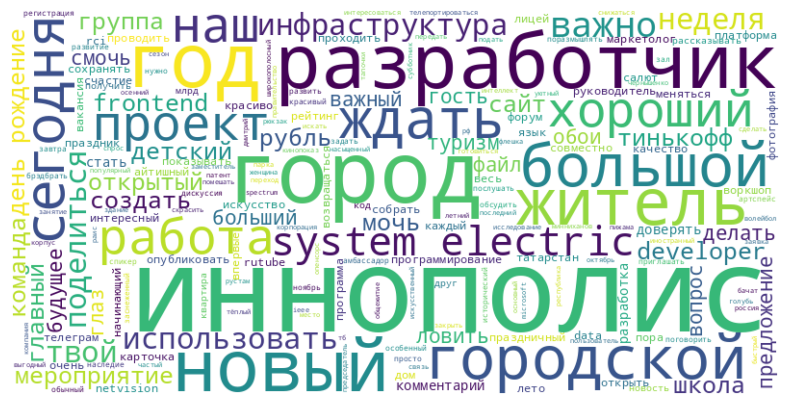

In [64]:
# Создание и отображение облака слов
wordcloud = WordCloud(
    background_color='white',
    width=800,
    height=400
).generate(text_for_wordcloud)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


Всего было выявлено 45 комментариев (в 33 публикакациях), в которых люди выражали желание приехать/перехать в Иннополис. Больше всего таких комментариев было под публикациями на тему "фото и эмоции"- 13, чуть меньше по теме "события" - 8. Еще встречались под публикациями на темы: "карьера", "подборки и ссылки", "стройка-жилье, "инновости" и "туризм".

Судя по облаку слов, чаще всего в выявленных публикациях (помимо "иннополис") встречаются слова: "город", "разработчик", "год", "новый", "житель" и др.

### Aнализ эмодзи

In [65]:
# Новая таблица для хранения распаршенных данных
parsed_data = pd.DataFrame(columns=['id', 'emodzi', 'cnt_emodzi'])

# Функция для парсинга словарей в отдельные колонки и заполнения новой таблицы
def parse_reactions(row):
    parsed_rows = []
    try:
        reactions = ast.literal_eval(row['reactions'])
        for reaction in reactions['results']:
            emoji = reaction['reaction'].get('emoticon', None)
            count = reaction['count']
            parsed_rows.append({'id': row['id'], 'emodzi': emoji, 'cnt_emodzi': count})
    except Exception as e:
        print(f"Error: {e}")
    return parsed_rows

# Применение функции к каждой строке и заполнение новой таблицы
for index, row in df_emoji.iterrows():
    parsed_rows = parse_reactions(row)
    parsed_data = parsed_data.append(parsed_rows, ignore_index=True)

<ipython-input-65-4eed451effce>:20: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-65-4eed451effce>:20: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-65-4eed451effce>:20: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-65-4eed451effce>:20: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-65-4eed451effce>:20: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-65-4eed451effce>:20: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Us

Error: invalid syntax (<unknown>, line 0)


<ipython-input-65-4eed451effce>:20: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-65-4eed451effce>:20: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-65-4eed451effce>:20: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-65-4eed451effce>:20: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-65-4eed451effce>:20: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-65-4eed451effce>:20: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Us

Error: invalid syntax (<unknown>, line 0)


<ipython-input-65-4eed451effce>:20: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-65-4eed451effce>:20: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-65-4eed451effce>:20: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-65-4eed451effce>:20: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-65-4eed451effce>:20: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-65-4eed451effce>:20: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Us

Error: invalid syntax (<unknown>, line 0)
Error: invalid syntax (<unknown>, line 0)
Error: invalid syntax (<unknown>, line 0)


<ipython-input-65-4eed451effce>:20: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-65-4eed451effce>:20: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-65-4eed451effce>:20: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-65-4eed451effce>:20: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-65-4eed451effce>:20: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-65-4eed451effce>:20: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Us

In [66]:
parsed_data_group = parsed_data.groupby('emodzi').agg({'id':'count', 'cnt_emodzi':'sum'}).sort_values(by='cnt_emodzi', ascending=False).reset_index()

In [67]:
parsed_data_group['mean_post'] = parsed_data_group['cnt_emodzi']/parsed_data_group['id']
display(parsed_data_group)

,emodzi,id,cnt_emodzi,mean_post
0,🔥,370,6189,16.727027
1,👍,496,5425,10.9375
2,❤,372,5247,14.104839
3,❤‍🔥,119,1662,13.966387
4,👏,184,1039,5.646739
5,🤣,63,930,14.761905
6,😍,92,765,8.315217
7,🎉,58,552,9.517241
8,💯,221,532,2.40724
9,🤔,108,449,4.157407


In [68]:
fig = px.bar(parsed_data_group ,  x='emodzi',  y='cnt_emodzi')
fig.update_layout(title='Распределение количества эмодзи во всех публикациях',
                   xaxis_title='эмодзи',
                   yaxis_title='количество')
fig.show()


Все эмодзи-реакции на публикации носят "положительный" окрас. Больше всего ставят реакции 🔥, 👍 и ❤.

## Выводы


Для анализа был представлен датасет, содержащий информацию о 539 публикациях из телеграмм-канала заказчика. И дополнительный датасет с комментариями к этим публикациям. Данные представлены за период с 1 марта 2022 года по 6 декабря 2023 года.

Для удобства анализа все публикации были разбиты на 10 тем.
Больше всего публикаций на тему "фото и эмоции" и "инновости", чуть меньше публикаций на тему "события". Получается, что канал в большей степени отображает насыщенную и интересную жизнь города.

Популярные темы (много реакций и комментариевна публикации): "фото и эмоции", "стройка-жилье".

Непопулярные темы (мало реакций и комментариев на публикации): "карьера" и "инновости".


Были рассчитаны средние показатели количества комментариев (4,83) и реакций (47,39) на публикацию и коэффициент вовлеченности (который равен сумме кол-ва комментариев и реакций, деленной на количество просмотров - 1,35%). На основании этих показателей  был выделен датасет с "эффективными" публикациями - у которых, все эти показатели выше средних (84 публикации - 15,5% от общего числа публикаций).

При анализе этих публикаций были получены следующие метрики "эффективной" публикации:
- небольшой объем текста;
- наличием эмоджи в тексте публикации
- тип публикации - с фото или видео файлом;
- публикация на тему "фото и эмоции" или "стройка-жилье".

Чаще всего публикации выходят в рабочее время 10-18 ч в будни дни. И комментарии чаще осталяют тоже в это время. После 19 часов вечера наблюдается значительный спад в комментариях.


Есть комментарии (45), в которых люди выражали желание приехать/перехать в Иннополис. Больше всего таких комментариев было под публикациями на тему "фото и эмоции"- 13, чуть меньше по теме "события" - 8.

Для увеличения лояльной аудитории канала рекомедуется увеличить число публикаций на тему "строительство-жилье". А так же добавить публикации, рассказывающие о местах необходимых для комфортной жизни в городе (кафе/магазины)
